#Customer Churn Analysis

**Note!!!**
###### This notebook is run on Databricks cloud website.

- Our aim in this project is to predict customer churn in the telecom sector depending on their personal information & history with the telecom company.

* The dataset contains 19 independent variables, below are their descriptions & possible values:

    * gender: Whether the client is a female or a male (Female, Male).
    * SeniorCitizen: Whether the client is a senior citizen or not ( 0, 1).
    * Partner: Whether the client has a partner or not (Yes, No).
    * Dependents: Whether the client has dependents or not (Yes, No).
    * tenure: Number of months the customer has stayed with the company (Multiple different numeric values).
    * Contract: Indicates the customer’s current contract type (Month-to-Month, One year, Two year).
    * PaperlessBilling: Whether the client has paperless billing or not (Yes, No).
    * PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit Card (automatic)).
    * MontlyCharges: The amount charged to the customer monthly (Multiple different numeric values).
    * TotalCharges: The total amount charged to the customer (Multiple different numeric values).
    * PhoneService: Whether the client has a phone service or not (Yes, No).
    * MultipleLines: Whether the client has multiple lines or not (No phone service, No, Yes).
    * InternetServices: Whether the client is subscribed to Internet service with the company (DSL, Fiber optic, No)
    * OnlineSecurity: Whether the client has online security or not (No internet service, No, Yes).
    * OnlineBackup: Whether the client has online backup or not (No internet service, No, Yes).
    * DeviceProtection: Whether the client has device protection or not (No internet service, No, Yes).
    * TechSupport: Whether the client has tech support or not (No internet service, No, Yes).
    * StreamingTV: Whether the client has streaming TV or not (No internet service, No, Yes).
    * StreamingMovies: Whether the client has streaming movies or not (No internet service, No, Yes).
    
* The dependent variable, which is our target for the classification process, is the "Churn". It indicates whether the customer departed within the last month or not. The class "No" includes the clients that did not leave the company last month, while the class "Yes" contains the clients that decided to terminate their relations with the company.

### Libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt 

import pyspark.sql.functions as f
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, Imputer, QuantileDiscretizer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import confusion_matrix
import itertools

### Data Import

In [0]:
# File location and type
file_location = "/FileStore/tables/WA_Fn_UseC__Telco_Customer_Churn.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df)

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes
9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.1,1949.4,No
6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.8,3046.05,Yes
6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [0]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [0]:
df = df.withColumn("TotalCharges",df.TotalCharges.cast('int'))

In [0]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: integer (nullable = true)
 |-- Churn: string (nullable = true)



### EDA

In [0]:
df.describe().show(vertical=True)

-RECORD 0--------------------------------
 summary          | count                
 customerID       | 7043                 
 gender           | 7043                 
 SeniorCitizen    | 7043                 
 Partner          | 7043                 
 Dependents       | 7043                 
 tenure           | 7043                 
 PhoneService     | 7043                 
 MultipleLines    | 7043                 
 InternetService  | 7043                 
 OnlineSecurity   | 7043                 
 OnlineBackup     | 7043                 
 DeviceProtection | 7043                 
 TechSupport      | 7043                 
 StreamingTV      | 7043                 
 StreamingMovies  | 7043                 
 Contract         | 7043                 
 PaperlessBilling | 7043                 
 PaymentMethod    | 7043                 
 MonthlyCharges   | 7043                 
 TotalCharges     | 7032                 
 Churn            | 7043                 
-RECORD 1-------------------------

In [0]:
#Check for Nan or Null values
df.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0---------------
 customerID       | 0   
 gender           | 0   
 SeniorCitizen    | 0   
 Partner          | 0   
 Dependents       | 0   
 tenure           | 0   
 PhoneService     | 0   
 MultipleLines    | 0   
 InternetService  | 0   
 OnlineSecurity   | 0   
 OnlineBackup     | 0   
 DeviceProtection | 0   
 TechSupport      | 0   
 StreamingTV      | 0   
 StreamingMovies  | 0   
 Contract         | 0   
 PaperlessBilling | 0   
 PaymentMethod    | 0   
 MonthlyCharges   | 0   
 TotalCharges     | 11  
 Churn            | 0   



In [0]:
# Create a view or table

temp_table_name = "churn_analysis"

df.createOrReplaceTempView(temp_table_name)

In [0]:
pd_df = df.toPandas()

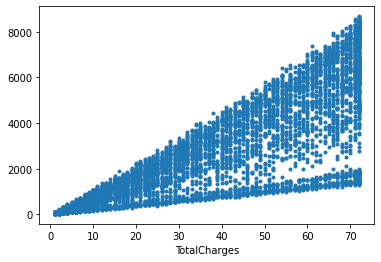

In [0]:
plt.clf()
plt.plot(pd_df["tenure"], pd_df["TotalCharges"], ".")
plt.xlabel("Tenure")
plt.xlabel("TotalCharges")
display()

In [0]:
df.groupBy("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



In [0]:
df.select("tenure", "MonthlyCharges", "TotalCharges").describe().show()

+-------+------------------+------------------+------------------+
|summary|            tenure|    MonthlyCharges|      TotalCharges|
+-------+------------------+------------------+------------------+
|  count|              7043|              7043|              7032|
|   mean| 32.37114865824223| 64.76169246059922| 2282.830489192264|
| stddev|24.559481023094442|30.090047097678482|2266.7684901298803|
|    min|                 0|             18.25|                18|
|    max|                72|            118.75|              8684|
+-------+------------------+------------------+------------------+



In [0]:
%sql 
select gender, churn, count(*) as count
from churn_analysis
group by gender, churn 

gender,churn,count
Male,No,2625
Male,Yes,930
Female,No,2549
Female,Yes,939


In [0]:
%sql 
select SeniorCitizen, churn, count(*) as count
from churn_analysis
group by SeniorCitizen, churn 

SeniorCitizen,churn,count
1,No,666
0,No,4508
0,Yes,1393
1,Yes,476


In [0]:
%sql 
select tenure, churn, count(*) as totalChurn
from churn_analysis
group by tenure, churn 
order by tenure

tenure,churn,totalChurn
0,No,11
1,No,233
1,Yes,380
2,No,115
2,Yes,123
3,No,106
3,Yes,94
4,No,93
4,Yes,83
5,No,69


As we see from above, the churn rate decreses as the tenure period increases.

In [0]:
#Then we would like to check the internet service type for senior citizens as they tend churn more than young
df.stat.crosstab("SeniorCitizen", "InternetService").show()

+-----------------------------+----+-----------+----+
|SeniorCitizen_InternetService| DSL|Fiber optic|  No|
+-----------------------------+----+-----------+----+
|                            0|2162|       2265|1474|
|                            1| 259|        831|  52|
+-----------------------------+----+-----------+----+



In [0]:
#Here we will check the frequent item for each categorical feature we have
df.stat.freqItems(["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "PaymentMethod"], 0.6).show(truncate = False, vertical=True)

-RECORD 0-------------------------------------------------
 PhoneService_freqItems     | [Yes]                       
 MultipleLines_freqItems    | [Yes]                       
 InternetService_freqItems  | [Fiber optic]               
 OnlineSecurity_freqItems   | [No]                        
 OnlineBackup_freqItems     | [Yes]                       
 DeviceProtection_freqItems | [No]                        
 TechSupport_freqItems      | [No]                        
 StreamingTV_freqItems      | [Yes]                       
 StreamingMovies_freqItems  | [No]                        
 PaymentMethod_freqItems    | [Bank transfer (automatic)] 



In [0]:
%sql 
select PaymentMethod, churn, count(*) as totalChurn
from churn_analysis
group by PaymentMethod, churn 

PaymentMethod,churn,totalChurn
Credit card (automatic),No,1290
Bank transfer (automatic),No,1286
Mailed check,Yes,308
Credit card (automatic),Yes,232
Electronic check,No,1294
Electronic check,Yes,1071
Bank transfer (automatic),Yes,258
Mailed check,No,1304


We see that churn increases when the payment method is "Electronic check"

In [0]:
#Python version of the SQL groupby
df.groupby(["PaymentMethod", "churn"]).agg(f.count("churn")).show()

+--------------------+-----+------------+
|       PaymentMethod|churn|count(churn)|
+--------------------+-----+------------+
|Credit card (auto...|   No|        1290|
|Bank transfer (au...|   No|        1286|
|        Mailed check|  Yes|         308|
|Credit card (auto...|  Yes|         232|
|    Electronic check|   No|        1294|
|    Electronic check|  Yes|        1071|
|Bank transfer (au...|  Yes|         258|
|        Mailed check|   No|        1304|
+--------------------+-----+------------+



###Model Building

#### Data Preprocessing

In [0]:
churn_df = df
(train_data, test_data) = churn_df.randomSplit([0.8, 0.2], seed = 1)

print(f"# of samples in train data: {train_data.count()}")
print(f"# of samples in test data: {test_data.count()}")

# of samples in train data: 5647
# of samples in test data: 1396


In [0]:
train_data.show(2)

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------+--------------+------------+-----+
|0002-ORFBO|Female|            0|    Yes|       Yes|     9|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|             No|      One

In [0]:
test_data.show(2)

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|0013-EXCHZ|Female|            1|    Yes|        No|     3|         Yes|           No|    Fiber optic|            No|          No|              No|        Yes|        Yes|    

In [0]:
#test_data.printSchema()

In [0]:
catCols = [c for (c, dataType) in churn_df.dtypes if ((dataType == "string") & (c != "Churn"))]
catCols

Out[22]: ['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [0]:
indexOutputCols = [c+"_Index" for c in catCols]
indexOutputCols

Out[23]: ['customerID_Index',
 'gender_Index',
 'Partner_Index',
 'Dependents_Index',
 'PhoneService_Index',
 'MultipleLines_Index',
 'InternetService_Index',
 'OnlineSecurity_Index',
 'OnlineBackup_Index',
 'DeviceProtection_Index',
 'TechSupport_Index',
 'StreamingTV_Index',
 'StreamingMovies_Index',
 'Contract_Index',
 'PaperlessBilling_Index',
 'PaymentMethod_Index']

#### Categorical Columns Processing
##### Using StringIndexer & OneHotEncoder

In [0]:
stringIndexer = StringIndexer(inputCols=catCols, outputCols=indexOutputCols, handleInvalid="keep")

In [0]:
oheOutputcols = [c+"_OHE" for c in catCols]

In [0]:
oheEncoder = OneHotEncoder(inputCols=indexOutputCols, outputCols=oheOutputcols)

In [0]:
labelIndexer = StringIndexer(inputCol="Churn", outputCol="label")

#### Numerical Columns Processing
##### Using Imputer & QuantileDiscretizer

In [0]:
imputer = Imputer(inputCol="TotalCharges", outputCol="Output_TotalCharges")

In [0]:
descretizer = QuantileDiscretizer(numBuckets=3, inputCol="tenure", outputCol="Binned_tenure")

##### Creating features Column

In [0]:
vecAssemblerInputs = oheOutputcols+ ["SeniorCitizen", "Output_TotalCharges","Binned_tenure"]

In [0]:
vecAssemblerInputs

Out[45]: ['customerID_OHE',
 'gender_OHE',
 'Partner_OHE',
 'Dependents_OHE',
 'PhoneService_OHE',
 'MultipleLines_OHE',
 'InternetService_OHE',
 'OnlineSecurity_OHE',
 'OnlineBackup_OHE',
 'DeviceProtection_OHE',
 'TechSupport_OHE',
 'StreamingTV_OHE',
 'StreamingMovies_OHE',
 'Contract_OHE',
 'PaperlessBilling_OHE',
 'PaymentMethod_OHE',
 'SeniorCitizen',
 'Output_TotalCharges',
 'Binned_tenure']

In [0]:
vecAssembler = VectorAssembler(inputCols=vecAssemblerInputs, outputCol="features")

#### Pipeline Model for Data Processing

In [0]:
pipeline = Pipeline(stages=[stringIndexer, oheEncoder, imputer, descretizer, labelIndexer, vecAssembler])

In [0]:
pipelineModel = pipeline.fit(train_data)

In [0]:
transformed_train_data = pipelineModel.transform(train_data)

In [0]:
transformed_test_data = pipelineModel.transform(test_data)

In [0]:
transformed_train_data.show(1)

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+----------------+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+----------------+-------------+-------------+--------------+----------------+-----------------+-------------------+------------------+----------------+--------------------+---------------+---------------+-------------------+-------------+--------------------+-----------------+-------------------+-------------+-----+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetServi

In [0]:
transformed_test_data.show(1)

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------+--------------+------------+-----+----------------+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+--------------+-------------+-------------+--------------+----------------+-----------------+-------------------+------------------+----------------+--------------------+---------------+---------------+-------------------+-------------+--------------------+-----------------+-------------------+-------------+-----+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetS

#### Training Logistic Regression Model

In [0]:
lr = LogisticRegression(labelCol="label", featuresCol="features")

In [0]:
lrModel = lr.fit(transformed_train_data)

In [0]:
predictions = lrModel.transform(transformed_test_data)

In [0]:
predictions.show(2)

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+----------------+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+--------------+-------------+-------------+--------------+----------------+-----------------+-------------------+------------------+----------------+--------------------+---------------+---------------+-------------------+-------------+--------------------+-----------------+-------------------+-------------+-----+--------------------+--------------------+--------------------+----------+
|customerID|gender|SeniorCitizen|Pa

In [0]:
predictions.select("features", "label", "prediction").show(2)

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(5691,[5648,5650,...|  1.0|       1.0|
|(5691,[5648,5649,...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 2 rows



#### Model Evaluation

In [0]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")

In [0]:
AUC = evaluator.evaluate(predictions)
print(f"Test Area under ROC {AUC}")

Test Area under ROC 0.6873866004534633


In [0]:
accuracy = predictions.filter(f.col("prediction")==f.col("label")).count() / float(predictions.count())
print(f"Accuracy score {accuracy}")

Accuracy score 0.8001432664756447


In [0]:
#Calculate Precision & Recall
tp = predictions.filter( (f.col("label")==1) & (f.col("label")==f.col("prediction"))).count()
fp = predictions.filter( (f.col("label")==0) & (f.col("label")!=f.col("prediction"))).count()
tn = predictions.filter( (f.col("label")==0) & (f.col("label")==f.col("prediction"))).count()
fn = predictions.filter( (f.col("label")==1) & (f.col("label")!=f.col("prediction"))).count()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(f"Precison score {precision}\nRecall score {recall}")

Precison score 0.657258064516129
Recall score 0.4565826330532213


In [0]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_true, y_pred)
print(f"Confusion Matrix\n{cm}")
#confusion_matrix
# plt.figure()
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
# thresh = cm.max() / 2
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j]),
#                  horizontalalignment="center",
#                  color="black")

# plt.colorbar()
# plt.show()

Confusion Matrix
[[954  85]
 [194 163]]


In [0]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

### Hyperparameter Tuning
#### Using Grid Search & Cross Validation

In [0]:
paramGrid = ParamGridBuilder()\
            .addGrid(lr.regParam, [0.01, 0.5, 2.0])\
            .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
            .addGrid(lr.maxIter, [5, 10, 20])\
            .build()

In [0]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [0]:
cvModel = cv.fit(transformed_train_data)

In [0]:
cvBestModel = cvModel.bestModel
cvPredictions = cvBestModel.transform(transformed_test_data)

In [0]:
cvAUC = evaluator.evaluate(cvPredictions)
print(f"Cross Validation Test Area under ROC {cvAUC}")

Cross Validation Test Area under ROC 0.7029720454110422


In [0]:
y_true_cv = cvPredictions.select("label")
y_true_cv = y_true_cv.toPandas()

y_pred_cv = cvPredictions.select("prediction")
y_pred_cv = y_pred_cv.toPandas()

cmCV = confusion_matrix(y_true_cv, y_pred_cv)
print(f"Confusion Matrix for Cross Validation\n{cmCV}")

Confusion Matrix for Cross Validation
[[934 105]
 [176 181]]
